<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment1/workbook-task1.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TODO: Modify this cell to add your group name, group number and your names and student IDs

Group: 42

Authors: Yaroslav Nazarov (1282875), Pol Timmer ()

In [3]:
import requests
import io
import pandas as pd
import xarray as xa

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Load training/testing dataset

In [4]:
def load_dataset_from_url(url):
    """
    Loads a dataset from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    x: Input features in numpy array format
    y: Targets/labels in numpy array format
    """
    
    response = requests.get(url)
    response.raise_for_status()
    
    dataset = np.load(io.BytesIO(response.content)) 
    
    x, y = np.split(dataset, [9], axis=2)
    
    return x, y

def load_dataset_from_disk(path):
    """
    Loads a dataset from disk. 
    
    Input:
    path: path to the dataset.
    
    Outputs:
    x: Input features in numpy array format
    y: Targets/labels in numpy array format
    """
    
    
    dataset = np.load(path)
    
    x, y = np.split(dataset, [9], axis=2)
    
    return x, y
    
    
# Downloading may take a while..
train_x, train_y = load_dataset_from_disk("A1T2_train.npy")
test_x, test_y = load_dataset_from_disk("A1T2_test.npy")


print(f"train_x shape: {train_x.shape}")
print(f"train_y shape: {train_y.shape}\n")

print(f"test_x shape: {test_x.shape}")
print(f"test_y shape: {test_y.shape}")

train_x shape: (10000, 1000, 9)
train_y shape: (10000, 1000, 1)

test_x shape: (2000, 1000, 9)
test_y shape: (2000, 1000, 1)


### Visualize some of the training samples

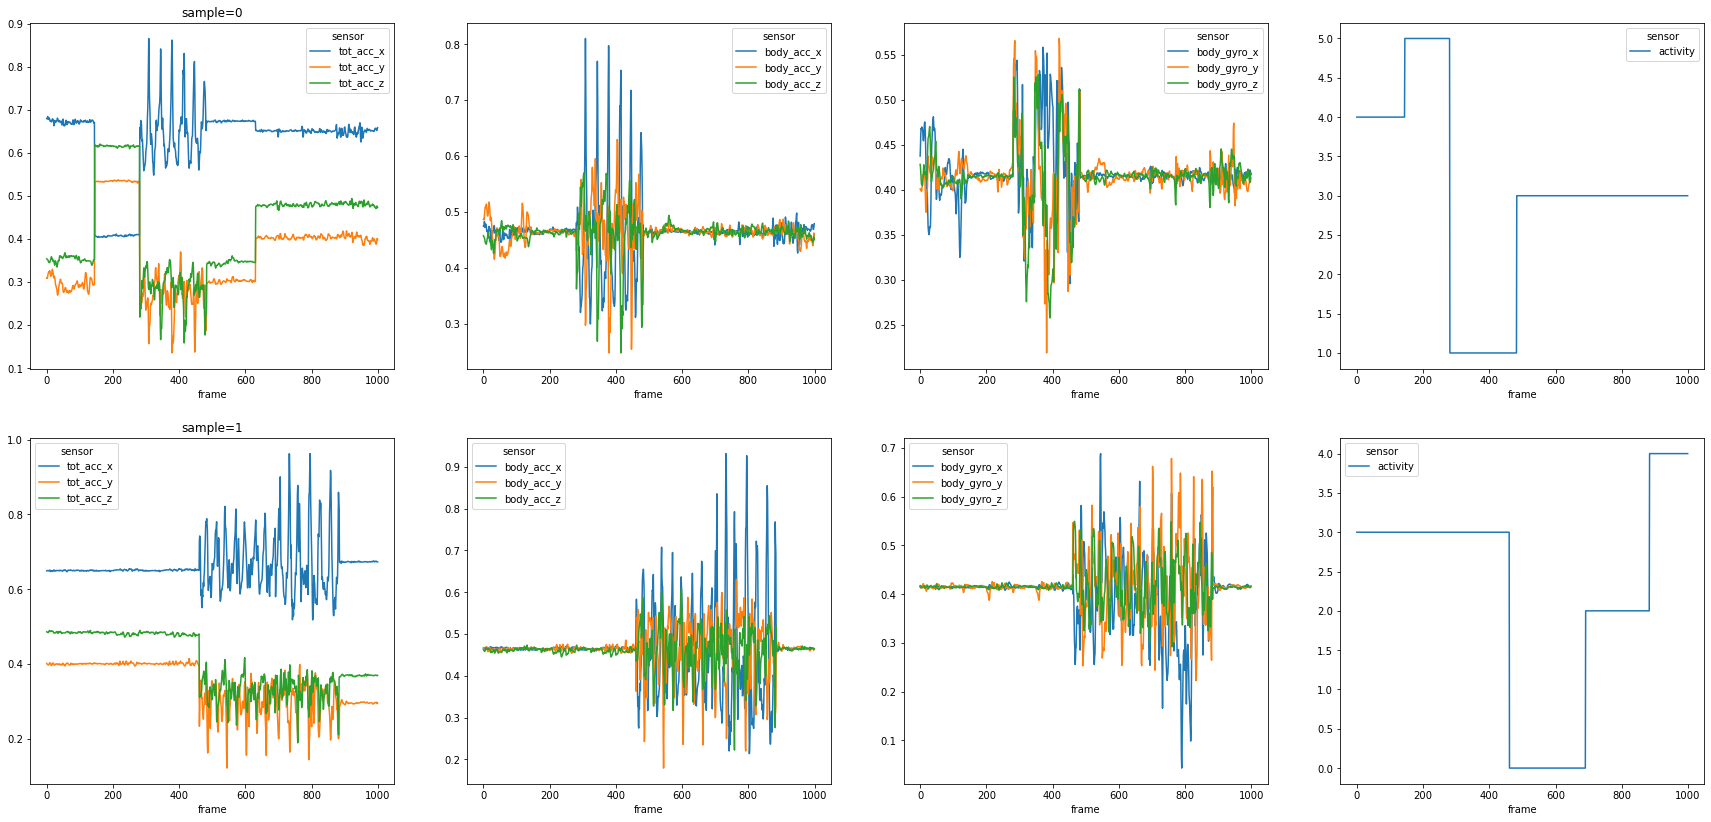

In [5]:
def to_df(x, y):
    """
    Converts training/testing input features and corresponding labels into
    a Pandas Dataframe format
    
    Inputs:
    x: Input features (train or test) in numpy array format
    y: Targets/labels (train or test) in numpy array format
    
    Output:
    dataset_df: Train or test data, structered as a table with column names
    """
    
    numpy_data = np.concatenate([x,y], axis=2)
    
    dataset_df = xa.DataArray(numpy_data, 
                                     dims = ['N', 'frame', 'sensor'],
                                     name='training_data')\
                                        .to_dataframe()\
                                        .unstack('sensor')['training_data']\
                                        .reset_index()

    column_names = ['tot_acc_x', 'tot_acc_y', 'tot_acc_z', 'body_acc_x', 'body_acc_y',
       'body_acc_z', 'body_gyro_x', 'body_gyro_y', 'body_gyro_z', 'activity']
    
    dataset_df = dataset_df.rename(columns = dict(zip(list(dataset_df.columns[2:]), 
                                                      column_names)))\
                                         .astype({'activity':int})

    return dataset_df



def plot_training_samples(N, dataset_df):
    """
    Plots samples in test/train dataset
    
    Inputs 
    N: Number of samples that will be visualised. 
    dataset_df: Train or test data, structered as a table with column names. 
                This tabular structured data can be obtained with `to_df` function.
    """
    
    f, axes = plt.subplots(N, 4, figsize=(30, N*7))
    axes = iter(axes)

    for pid, df_pid in list(dataset_df.groupby('N'))[:N]:

        ax_tot_acc, ax_body_acc, ax_body_gyro, ax_activity = tuple(next(axes))

        df_pid.plot(x = 'frame', y=['tot_acc_x','tot_acc_y', 'tot_acc_z'], title=f'sample={pid}', ax=ax_tot_acc)
        df_pid.plot(x = 'frame', y=['body_acc_x','body_acc_y', 'body_acc_z'], ax=ax_body_acc)
        df_pid.plot(x = 'frame', y=['body_gyro_x','body_gyro_y', 'body_gyro_z'], ax=ax_body_gyro)
        df_pid.plot(x = 'frame', y=['activity'], ax=ax_activity) 
        
    
    

training_data_df = to_df(train_x, train_y)

plot_training_samples(2, training_data_df);

In [1]:
#TODO Implement the solution to task 2 of assignment 1